# Problem 1: Python & Data Exploration 

In [1]:
# Write and run your code here 
 #!pip3 install -r requirements.txt # install requirements.txt pip packages

### Import Libraries & Load Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
iris = np.genfromtxt("data/iris.txt",delimiter=None) # load the text file 
Y = iris[:,-1] # target value is the last column
X = iris[:,0:-1] # features are the other columns

### 1.1 Use X.shape to get the number of features and the data points. Report both numbers, mentioning which number is which.

In [4]:
X.shape

(148, 4)

There are 148 records each of which has 4 features (columns).

### 1.2 For each feature, plot a histogram ( plt.hist ) of the data values <br> & <br> 1.3 Compute the mean & standard deviation of the data points for each feature ( np.mean , np.std )

#### Extract each set of features into separate arrays

Feature 1, shape: (148,)
Feature Statistics: (rounded) mean = 5.9, (rounded) standard deviation = 0.833
Histogram:


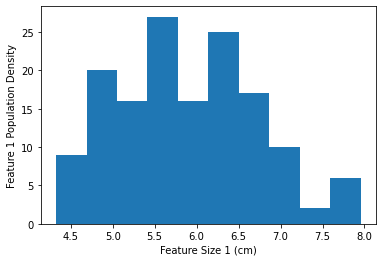

Feature 2, shape: (148,)
Feature Statistics: (rounded) mean = 3.099, (rounded) standard deviation = 0.436
Histogram:


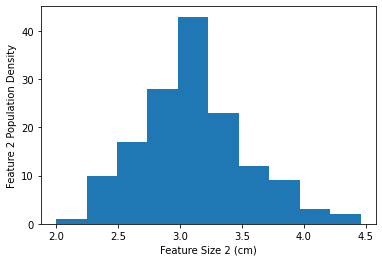

Feature 3, shape: (148,)
Feature Statistics: (rounded) mean = 3.82, (rounded) standard deviation = 1.754
Histogram:


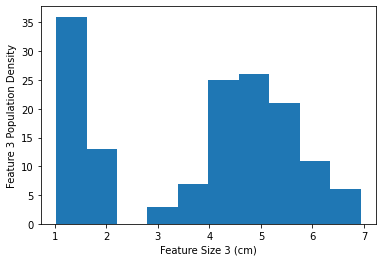

Feature 4, shape: (148,)
Feature Statistics: (rounded) mean = 1.253, (rounded) standard deviation = 0.759
Histogram:


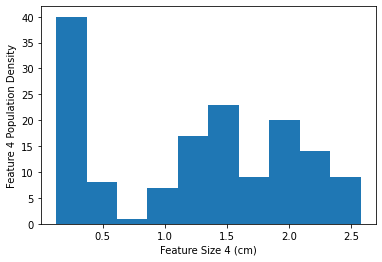

In [5]:
features = np.array([X[:,i] for i in range(len(X[1]))])
for i, feature in enumerate(features):
        print(f'Feature {i+1}, shape: {feature.shape}')
        feature_mu = round(np.mean(feature, axis=0), 3)
        feature_sigma = round(np.std(feature, axis=0), 3)
        print(f'Feature Statistics: (rounded) mean = {feature_mu}, (rounded) standard deviation = {feature_sigma}')
        print('Histogram:')
        plt.hist(feature)
        plt.xlabel(f"Feature Size {i+1} (cm)")
        plt.ylabel(f"Feature {i+1} Population Density")
        plt.show()

### 1.4 For each pair of features (1,2), (1,3), and (1,4), plot a scatterplot (see plt.plot or plt.scatter ) of the feature values, colored according to their target value (class). (For example, plot all data points with y = 0 as blue, y = 1 as green, etc.)

In [6]:
np.unique(Y)

array([0., 1., 2.])

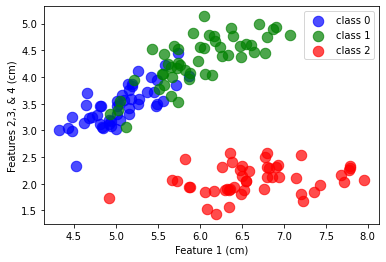

In [7]:
colors = ['blue', 'green', 'red']

for i, class_label in enumerate(np.unique(Y)):
    # mask is boolean array for determining whether or not to consider a record from a feature array as the class sample iteration
    mask = Y == class_label
    plt.scatter(X[mask, 0], X[mask, i + 1], s=110, c=colors[i], alpha=0.70, label='class %d' % i)

plt.xlabel('Feature 1 (cm)')
plt.ylabel(f'Features 2,3, & 4 (cm)')
plt.legend()
plt.show()

# Problem 2: k-Nearest Neighbor (kNN) exercise


The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [8]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs273p.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# %load_ext autoreload
# %autoreload 2

In [9]:
%cd cs273p/datasets
!source get_datasets.sh

/Users/Tarek/Documents/UCI_MDS_Coding/cs273P/hw/1-Homework/hw1/cs273p/datasets
--2023-01-20 00:05:20--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  33.2MB/s    in 5.4s    

2023-01-20 00:05:26 (29.9 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

x cifar-10-batches-py/
x cifar-10-batches-py/data_batch_4
x cifar-10-batches-py/readme.html
x cifar-10-batches-py/test_batch
x cifar-10-batches-py/data_batch_3
x cifar-10-batches-py/batches.meta
x cifar-10-batches-py/data_batch_2
x cifar-10-batches-py/data_batch_5
x cifar-10-batches-py/data_batch_1


In [10]:
%cd ../..

/Users/Tarek/Documents/UCI_MDS_Coding/cs273P/hw/1-Homework/hw1


In [11]:
# Load the raw CIFAR-10 data.
cifar10_dir = './cs273p/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


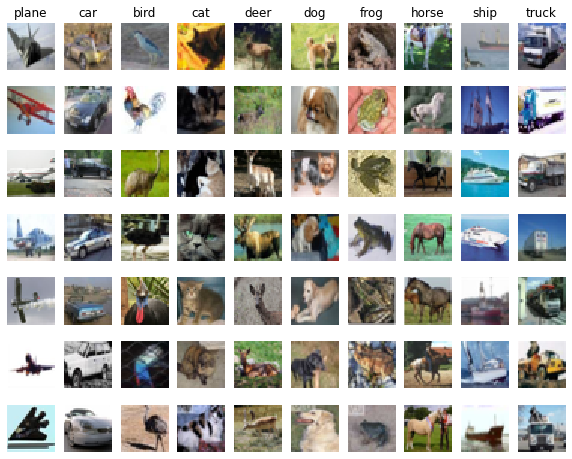

In [12]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [13]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [14]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


#### Each image (X) record is now a flattened array of length 3072 consisting of rgb values ranging from 0-255

In [15]:
X_train[0].shape, np.unique(X_train[0])

((3072,),
 array([  0.,   4.,   5.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,
         15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,
         26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,
         37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
         48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,
         59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,
         70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,
         81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,
         92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102.,
        103., 104., 105., 106., 107., 108., 109., 110., 111., 112., 113.,
        114., 115., 116., 117., 118., 119., 120., 121., 122., 123., 124.,
        125., 126., 127., 128., 129., 130., 131., 132., 133., 134., 135.,
        136., 137., 138., 139., 140., 141., 142., 143., 144., 145., 146.,
        147., 148., 149., 15

#### Each image (Y) record is the class label (0-9) of the same image (from same respective index of X array)

In [16]:
y_train.shape, np.unique(y_train)

((5000,), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [17]:
for i in range(5):
        print(f'Index {i}, Sample {y_train[i]}')

Index 0, Sample 6
Index 1, Sample 9
Index 2, Sample 9
Index 3, Sample 4
Index 4, Sample 1


In [18]:
from cs273p.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `cs273p/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [19]:
# Open cs273p/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


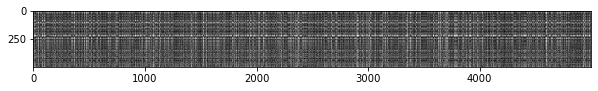

In [20]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question #1:** Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

**Answer:**<br><br>
Inline 1.1) 
- Each row corresponds to a single record of the test data array. All of a row's columns are its distances relative to each of the train data points. The reason some rows are brighter is because the image corresponding to the row must be one of the class labels that is very distinct from all of the other class labels. For example, an image of a plane looks very different compared to the other classes of images.
Inline 1.2)
- Each column corresponds to a single record of the train data array. All of a column's rows are its distances relative to each of the test data points. The reason some columns are brighter is because the image corresponding to the column must be one of the class labels that is very distinct from all of the other class labels, such as an image of a plane.

In [21]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [22]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

In [23]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [24]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [25]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 30.901932 seconds
One loop version took 31.923514 seconds
No loop version took 0.177272 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [43]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################

for k in k_choices:
    for fold in range(num_folds):
        validation_X_test = X_train_folds[fold]
        validation_y_test = y_train_folds[fold]
        temp_X_train = np.concatenate(X_train_folds[:fold] + X_train_folds[fold + 1:])
        temp_y_train = np.concatenate(y_train_folds[:fold] + y_train_folds[fold + 1:])

        #Initializing a class
        test_classifier = KNearestNeighbor()
        test_classifier.train( temp_X_train, temp_y_train )
        
        #Computing the distance
        temp_dists = test_classifier.compute_distances_no_loops(validation_X_test)
        temp_y_test_pred = test_classifier.predict_labels(temp_dists, k=k)
        
        #Checking accuracies
        num_correct = np.sum(temp_y_test_pred == validation_y_test)
        num_test = validation_X_test.shape[0]
        accuracy = float(num_correct) / num_test
        print(f"k = {k}, fold = {fold}, accuracy = {accuracy}")
        if k not in k_to_accuracies:
            k_to_accuracies[k] = [accuracy]
        else:
            k_to_accuracies[k] = k_to_accuracies[k] + [accuracy]

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, fold = 0, accuracy = 0.263
k = 1, fold = 1, accuracy = 0.257
k = 1, fold = 2, accuracy = 0.264
k = 1, fold = 3, accuracy = 0.278
k = 1, fold = 4, accuracy = 0.266
k = 3, fold = 0, accuracy = 0.239
k = 3, fold = 1, accuracy = 0.249
k = 3, fold = 2, accuracy = 0.24
k = 3, fold = 3, accuracy = 0.266
k = 3, fold = 4, accuracy = 0.254
k = 5, fold = 0, accuracy = 0.248
k = 5, fold = 1, accuracy = 0.266
k = 5, fold = 2, accuracy = 0.28
k = 5, fold = 3, accuracy = 0.292
k = 5, fold = 4, accuracy = 0.28
k = 8, fold = 0, accuracy = 0.262
k = 8, fold = 1, accuracy = 0.282
k = 8, fold = 2, accuracy = 0.273
k = 8, fold = 3, accuracy = 0.29
k = 8, fold = 4, accuracy = 0.273
k = 10, fold = 0, accuracy = 0.265
k = 10, fold = 1, accuracy = 0.296
k = 10, fold = 2, accuracy = 0.276
k = 10, fold = 3, accuracy = 0.284
k = 10, fold = 4, accuracy = 0.28
k = 12, fold = 0, accuracy = 0.26
k = 12, fold = 1, accuracy = 0.295
k = 12, fold = 2, accuracy = 0.279
k = 12, fold = 3, accuracy = 0.283
k = 12, fol

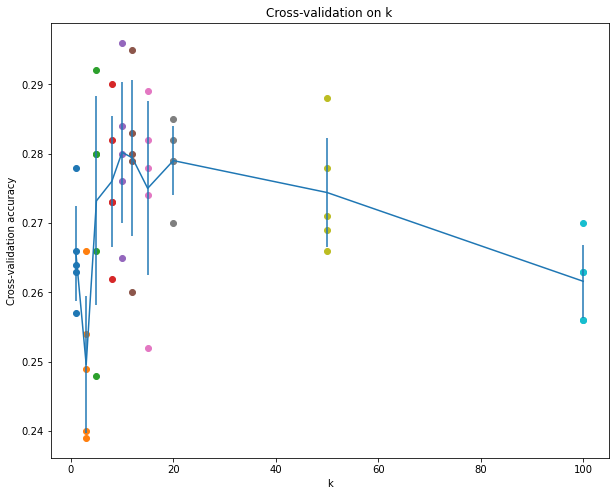

In [44]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [46]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = k_choices[np.argmax(accuracies_mean)]

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)
num_test = len(X_test)
# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


# Problem 3: Naïve Bayes Classifiers


You don't need to code this question. You can either type your answer or attach an image of hand written solution here.